## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report

import matplotlib.pyplot as plt

In [2]:
DATAFILE = '../ad_campaign_data.csv' # location of dataset
random_state = None # change to something for exactly reproducible results

# as selected in "tutorial_bias_advertising" notebook
selected_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated', 'homeowner']
cate_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated']
num_features = ['homeowner']

# if not specified, set to 1
feature_weights = {"gender": 1, "parents": 1, "age": 1}

target_name = "true_conversion"
positive_label = 1
negative_label = 0

model_train_fraction = 0.7
learning_class_weights = {0: 0.5, 1: 265}

sensitive_attribute = "gender"
sensitive_alias = {"M": "Male", "F": "Female", "Unknown": "Unknown"}

In [3]:
# collect necessary parameters into a ParameterProxy object

comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Load Dataset

In [4]:
ad_conversion_dataset = pd.read_csv(DATAFILE)
ad_conversion_dataset.head()

,religion,politics,college_educated,parents,homeowner,gender,age,income,area,true_conversion,predicted_conversion,predicted_probability
0,Unknown,Unknown,1,1,1,Unknown,55-64,Unknown,Unknown,0,0,0.001351
1,Other,Unknown,1,1,1,Unknown,55-64,Unknown,Urban,0,0,0.002238
2,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.002704
3,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.001967
4,Unknown,Unknown,1,1,1,F,55-64,Unknown,Urban,0,0,0.001681


In [5]:
ad_conversion_dataset.gender = ad_conversion_dataset.gender.map(sensitive_alias)

### Print some statistics for the dataset

In [6]:
print(f"Number of (instances, attributes) in the dataset = {ad_conversion_dataset.shape}")
print()

print(f"Statistics of true conversions (0=no, 1=yes)")
print(ad_conversion_dataset.true_conversion.value_counts())
print()

print(f"Statistics of predicted conversions (0=no, 1=yes)")
print(ad_conversion_dataset.predicted_conversion.value_counts())

Number of (instances, attributes) in the dataset = (1443140, 12)

Statistics of true conversions (0=no, 1=yes)
0    1440766
1       2374
Name: true_conversion, dtype: int64

Statistics of predicted conversions (0=no, 1=yes)
0    1440773
1       2367
Name: predicted_conversion, dtype: int64


### Warning!

There is no model!

Predictions (from whatever model has been used) have been incorporated into the dataset, in the columns "predicted_conversion" (which is the predicted label) and "predicted_probability" (which is the predicted probability of belonging to the positive class).

Moreover, the dataset is highly unbalanced, and this is also evident in the poor efficiency of the model, as demonstrated in the confusion matrix below.

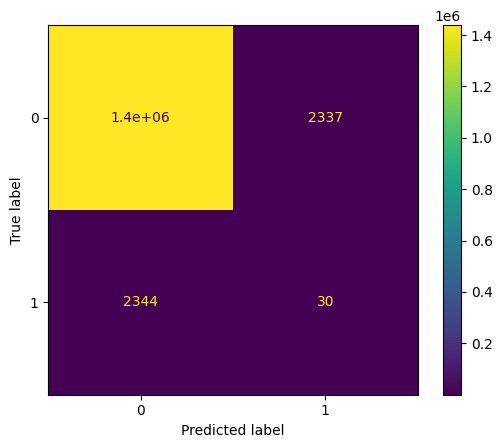

In [7]:
conf_matrix = confusion_matrix(ad_conversion_dataset.true_conversion, ad_conversion_dataset.predicted_conversion)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Preprocessing

In [8]:
## keep only the columns in selected_features, plus the label column
ad_conversion_dataset = ad_conversion_dataset[selected_features + [target_name]]
ad_conversion_dataset

,gender,parents,age,income,area,college_educated,homeowner,true_conversion
0,Unknown,1,55-64,Unknown,Unknown,1,1,0
1,Unknown,1,55-64,Unknown,Urban,1,1,0
2,Female,1,55-64,Unknown,Unknown,1,1,0
3,Female,1,55-64,Unknown,Unknown,1,1,0
4,Female,1,55-64,Unknown,Urban,1,1,0
...,...,...,...,...,...,...,...,...
1443135,Female,1,25-34,Unknown,Unknown,1,1,0
1443136,Female,1,55-64,Unknown,Unknown,1,0,0
1443137,Unknown,1,55-64,Unknown,Unknown,1,1,0
1443138,Female,1,55-64,Unknown,Unknown,1,1,0


In [9]:
## train-test split

X = ad_conversion_dataset.drop(target_name, axis=1)
y = ad_conversion_dataset[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=model_train_fraction, random_state=random_state, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Model training

In [10]:
%%time

model = customLogisticRegression(class_weight=learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column=target_name)
model.predict(X_test.iloc[:100, :])

Wall time: 13 s


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Testing the model

We check if the model is satisfactory.

In [11]:
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    432231
           1       0.00      0.11      0.00       712

    accuracy                           0.90    432943
   macro avg       0.50      0.51      0.48    432943
weighted avg       1.00      0.90      0.95    432943



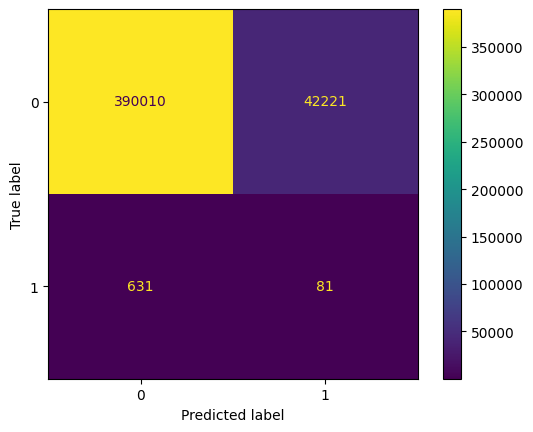

In [12]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

Given the high imbalance of the dataset, we consider that the above results, for a simple logistic regression, are good enough.

# Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [16]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model,
    sensitive_attribute,
    missing_subgroup_val="Unknown"
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:03<00:00,  1.82s/it]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 2/2 [00:00<00:00, 52.94it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████| 380/380 [00:00<00:00, 1348.36it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 558/558 [02:21<00:00,  3.95it/s]

Number of if-thens: 558


Uncomment the following block if you wish to load rules object from disk.

In [13]:
import dill

with open("rules.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [17]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Male"][1][0][1]-e[1]["Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If age = 25-34, college_educated = 1, area = Unknown, parents = 1, income = Unknown:
	Subgroup 'Female', 1.05% covered
		Make area = Urban with correctness 0.00%.
	Subgroup 'Male', 1.08% covered
		Make area = Urban with correctness 100.00%.
If area = Urban, age = 55-64, parents = 1, college_educated = 1:
	Subgroup 'Female', 19.76% covered
		Make age = 25-34 with correctness 0.10%.
	Subgroup 'Male', 20.82% covered
		Make age = 25-34 with correctness 98.66%.
If area = Urban, age = 55-64, parents = 1, income = Unknown:
	Subgroup 'Female', 20.65% covered
		Make age = 25-34 with correctness 0.00%.
	Subgroup 'Male', 21.81% covered
		Make age = 25-34 with correctness 94.17%.
If age = 55-64, income = Unknown, parents = 1, area = Unknown:
	Subgroup 'Female', 58.05% covered
		Make area = Rural with correctness 0.91%.
	Subgroup 'Male', 61.01% covered
		Make area = Rural with correctness 94.40%.
If area = Urban, age = 55-64, college_educated = 1:
	Subgroup 'Female', 20.94% covered
		Make age = 25-

In [16]:
# #### Uncomment if you wish to save rules object on disk

# import dill

# with open("rules.data", "wb") as outf:
#     dill.dump(rules_by_if, outf)

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

## Weighted Average Score

In [18]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If income = <100K, parents = 1, area = Unknown, homeowner = 0:
	Subgroup 'Female', 1.35% covered out of 600135
		Make income = Unknown with correctness 89.64%.
		Make income = Unknown, area = Rural, homeowner = 1 with correctness 1.88%.
		Aggregate cost of the above recourses = -0.48
	Subgroup 'Male', 1.48% covered out of 314181
		Make income = Unknown with correctness 92.52%.
		Make income = Unknown, area = Rural, homeowner = 1 with correctness 90.45%.
		Aggregate cost of the above recourses = -1.82
	Bias against Female. Unfairness measure = 1.34.
If income = <100K, area = Unknown, college_educated = 1, homeowner = 0:
	Subgroup 'Female', 1.34% covered out of 600135
		Make income = Unknown with correctness 90.13%.
		Make income = Unknown, area = Rural, homeowner = 1 with correctness 1.89%.
		Aggregate cost of the above recourses = -0.48
	Subgroup 'Male', 1.49% covered out of 314181
		Make income = Unknown with correctness 91.75%.
		Make income = Unknown, area = Rural, homeowner = 1 wit

## Minimum cost above threshold

In [19]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If area = Unknown:
	Subgroup 'Female', 71.29% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 74.57% covered out of 314181
		Make area = Rural with correctness 82.32%.
		Aggregate cost of the above recourses = 1.00
	Bias against Female. Unfairness measure = inf.
If parents = 1, area = Unknown:
	Subgroup 'Female', 66.99% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 70.10% covered out of 314181
		Make area = Rural with correctness 86.75%.
		Aggregate cost of the above recourses = 1.00
	Bias against Female. Unfairness measure = inf.
If income = Unknown, area = Unknown:
	Subgroup 'Female', 66.60% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 69.59% covered out of 314181
		Make area = Rural with correctness 85.14%.
		Aggregate cost of the above recourses = 1.00
	Bias agains

## Mean cost above threshold

In [20]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If area = Unknown:
	Subgroup 'Female', 71.29% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 74.57% covered out of 314181
		Make area = Rural with correctness 82.32%.
		Aggregate cost of the above recourses = 1.00
	Bias against Female. Unfairness measure = inf.
If parents = 1, area = Unknown:
	Subgroup 'Female', 66.99% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 70.10% covered out of 314181
		Make area = Rural with correctness 86.75%.
		Aggregate cost of the above recourses = 1.00
	Bias against Female. Unfairness measure = inf.
If income = Unknown, area = Unknown:
	Subgroup 'Female', 66.60% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 69.59% covered out of 314181
		Make area = Rural with correctness 85.14%.
		Aggregate cost of the above recourses = 1.00
	Bias agains

## Number above threshold

In [21]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If area = Unknown:
	Subgroup 'Female', 71.29% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Subgroup 'Male', 74.57% covered out of 314181
		Make area = Rural with correctness 82.32%.
		Aggregate cost of the above recourses = -1.00
	Bias against Female. Unfairness measure = 1.
If area = Unknown, homeowner = 1:
	Subgroup 'Female', 67.49% covered out of 600135
		Make homeowner = 0 with correctness 81.95%.
		Make area = Urban, homeowner = 0 with correctness 89.90%.
		Aggregate cost of the above recourses = -2.00
	Subgroup 'Male', 70.63% covered out of 314181
		Make homeowner = 0 with correctness 83.82%.
		Make area = Rural with correctness 82.24%.
		Make area = Urban, homeowner = 0 with correctness 96.45%.
		Aggregate cost of the above recourses = -3.00
	Bias against Female. Unfairness measure = 1.
If parents = 1, area = Unknown:
	Subgroup 'Female', 66.99% covered out of 600135
		No recourses for this subgroup!
		Aggregate cost of t

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [21]:
import dill

with open("state.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

If income = <100K, parents = 1, area = Unknown, homeowner = 0:
	Subgroup 'Female', 1.35% covered out of 600135
		Make income = Unknown with correctness 89.64%.
		Make income = Unknown, area = Rural, homeowner = 1 with correctness 1.88%.
	Subgroup 'Male', 1.48% covered out of 314181
		Make income = Unknown with correctness 92.52%.
		Make income = Unknown, area = Rural, homeowner = 1 with correctness 90.45%.
	Bias against Female. Unfairness measure = 1.34.
	Cumulative correctness plot for the above recourses:


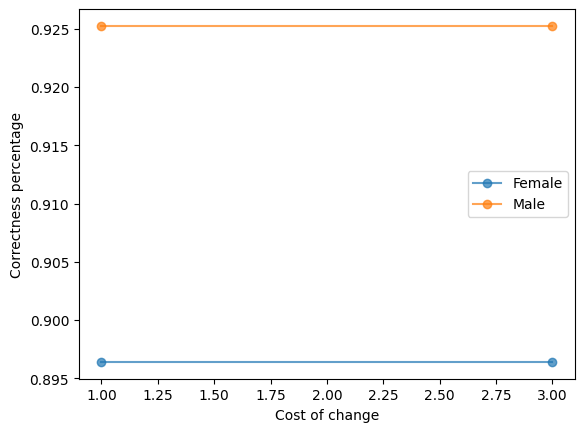

If income = <100K, area = Unknown, college_educated = 1, homeowner = 0:
	Subgroup 'Female', 1.34% covered out of 600135
		Make income = Unknown with correctness 90.13%.
		Make income = Unknown, area = Rural, homeowner = 1 with correctness 1.89%.
	Subgroup 'Male', 1.49% covered out of 314181
		Make income = Unknown with correctness 91.75%.
		Make income = Unknown, area = Rural, homeowner = 1 with correctness 89.85%.
	Bias against Female. Unfairness measure = 1.33.
	Cumulative correctness plot for the above recourses:


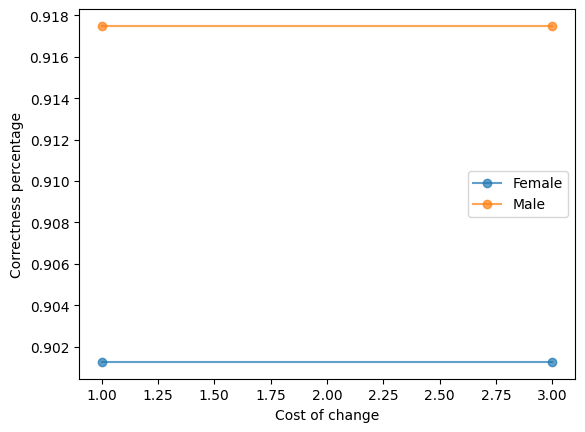

If income = <100K, area = Unknown, homeowner = 0:
	Subgroup 'Female', 1.44% covered out of 600135
		Make income = Unknown with correctness 84.38%.
		Make income = Unknown, area = Rural, homeowner = 1 with correctness 1.77%.
	Subgroup 'Male', 1.57% covered out of 314181
		Make income = Unknown with correctness 87.24%.
		Make income = Unknown, area = Rural, homeowner = 1 with correctness 85.28%.
	Bias against Female. Unfairness measure = 1.27.
	Cumulative correctness plot for the above recourses:


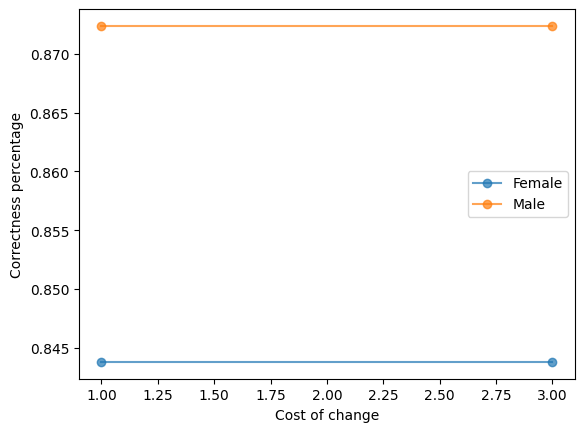

If age = 25-34, college_educated = 1, area = Unknown, parents = 1, income = Unknown:
	Subgroup 'Female', 1.05% covered out of 600135
		Make area = Urban with correctness 0.00%.
	Subgroup 'Male', 1.08% covered out of 314181
		Make area = Urban with correctness 100.00%.
	Bias against Female. Unfairness measure = 1.0.
	Cumulative correctness plot for the above recourses:


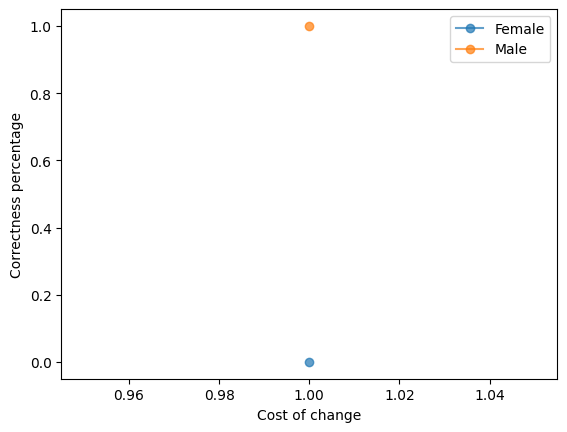

If age = 45-54, college_educated = 1, area = Unknown, parents = 1, income = Unknown, homeowner = 1:
	Subgroup 'Female', 1.02% covered out of 600135
		Make age = 25-34, homeowner = 0 with correctness 100.00%.
		Make age = 25-34, area = Urban with correctness 0.00%.
	Subgroup 'Male', 1.03% covered out of 314181
		Make age = 25-34, homeowner = 0 with correctness 100.00%.
		Make age = 25-34, area = Urban with correctness 100.00%.
	Bias against Female. Unfairness measure = 1.0.
	Cumulative correctness plot for the above recourses:


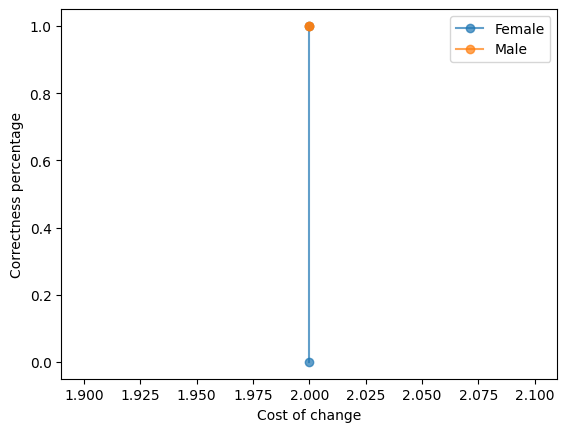

If age = 45-54, college_educated = 1, area = Unknown, parents = 1, homeowner = 1:
	Subgroup 'Female', 1.07% covered out of 600135
		Make age = 25-34, homeowner = 0 with correctness 95.69%.
		Make age = 25-34, area = Urban with correctness -0.00%.
	Subgroup 'Male', 1.07% covered out of 314181
		Make age = 25-34, homeowner = 0 with correctness 97.94%.
		Make age = 25-34, area = Urban with correctness 96.44%.
	Bias against Female. Unfairness measure = 0.99.
	Cumulative correctness plot for the above recourses:


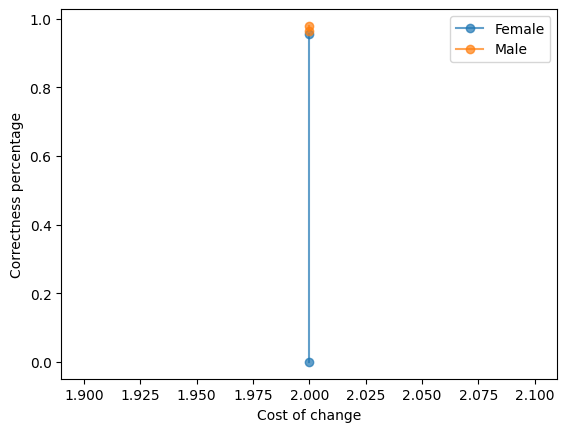

If area = Urban, age = 55-64, parents = 1, college_educated = 1:
	Subgroup 'Female', 19.76% covered out of 600135
		Make age = 25-34 with correctness 0.10%.
	Subgroup 'Male', 20.82% covered out of 314181
		Make age = 25-34 with correctness 98.66%.
	Bias against Female. Unfairness measure = 0.99.
	Cumulative correctness plot for the above recourses:


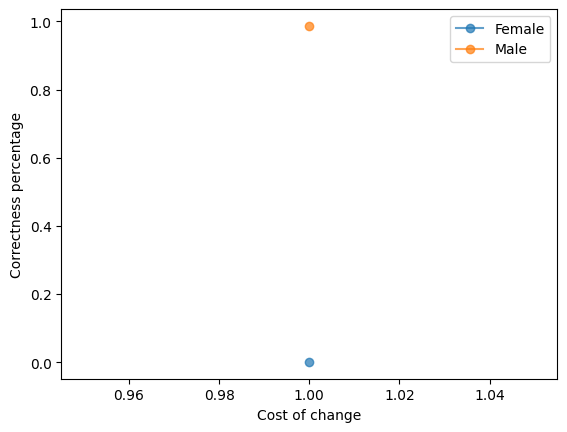

If area = Urban, age = 55-64, college_educated = 0, homeowner = 1:
	Subgroup 'Female', 1.26% covered out of 600135
		Make college_educated = 1, homeowner = 0 with correctness 94.17%.
		Make age = 25-34, college_educated = 1 with correctness 0.00%.
	Subgroup 'Male', 1.37% covered out of 314181
		Make college_educated = 1, homeowner = 0 with correctness 100.00%.
		Make age = 25-34, college_educated = 1 with correctness 92.67%.
	Bias against Female. Unfairness measure = 0.98.
	Cumulative correctness plot for the above recourses:


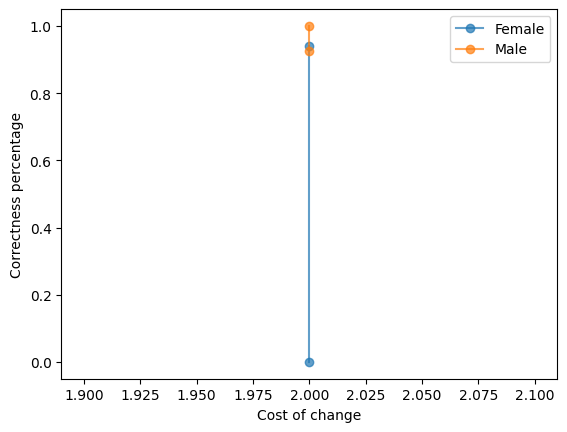

If area = Urban, age = 55-64, parents = 1, college_educated = 0:
	Subgroup 'Female', 1.19% covered out of 600135
		Make college_educated = 1 with correctness 0.10%.
		Make age = 25-34, college_educated = 1 with correctness 0.15%.
	Subgroup 'Male', 1.30% covered out of 314181
		Make college_educated = 1 with correctness 0.19%.
		Make age = 25-34, college_educated = 1 with correctness 98.30%.
	Bias against Female. Unfairness measure = 0.98.
	Cumulative correctness plot for the above recourses:


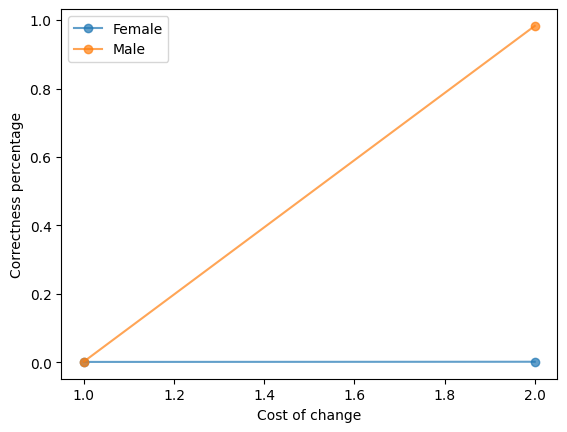

If area = Urban, age = 55-64, parents = 0, college_educated = 1:
	Subgroup 'Female', 1.18% covered out of 600135
		Make parents = 1 with correctness 1.23%.
		Make age = 25-34, parents = 1 with correctness 1.39%.
	Subgroup 'Male', 1.23% covered out of 314181
		Make parents = 1 with correctness 0.20%.
		Make age = 25-34, parents = 1 with correctness 99.10%.
	Bias against Female. Unfairness measure = 0.97.
	Cumulative correctness plot for the above recourses:


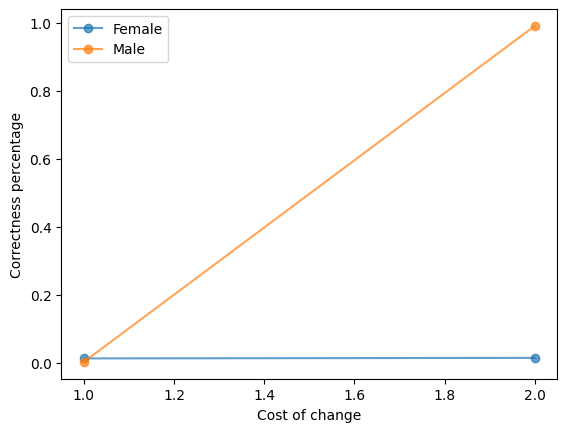

In [22]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="weighted-average",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute=sensitive_attribute)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [23]:
# import dill

# with open("state.data", "wb") as outf:
#     dill.dump((rules_by_if, model, X_test), outf)